Simple use the FFT to fit history tide data.  

Data from https://tidesandcurrents.noaa.gov/waterlevels.html?id=9414290&units=standard&bdate=20190701&edate=20190801&timezone=GMT&datum=MLLW&interval=6&action=data

In [1]:
import math
import datetime
import pytz
import glob
import functools
import operator
import numpy
import pandas
import matplotlib.pyplot
import matplotlib.pylab
import seaborn
import sklearn.linear_model
import sklearn.metrics
import vtreat.cross_plan

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
date_fmt = '%Y/%m/%d %H:%M'
tz = pytz.utc
    
def parse_date(dtstr):
    d0 = datetime.datetime.strptime(dtstr, date_fmt)
    return d0.replace(tzinfo=tz)

base_date_time = datetime.datetime(2001, 1, 1, tzinfo=tz)
first_date_time = datetime.datetime(2019, 6, 1, tzinfo=tz)
cut_date_time = datetime.datetime(2019, 7, 15, tzinfo=tz)

In [3]:
print("TZ NAME: {tz}".format(tz=base_date_time.tzname()))

TZ NAME: UTC


In [4]:
d0 = parse_date('2001/01/01 00:00')
(d0 - base_date_time).total_seconds()

0.0

In [5]:
print("TZ NAME: {tz}".format(tz=d0.tzname()))

TZ NAME: UTC


In [6]:
tides = pandas.read_pickle('tides.pickle.gz')

In [7]:
tides['train'] = tides['dt']<cut_date_time

In [8]:
tides.head()

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft),dt,dts,tide feet,train
0,2017/01/01,00:00,1.849,NaN,2.12,2017-01-01 00:00:00+00:00,504921600.0,2.12,True
1,2017/01/01,00:06,1.695,NaN,1.97,2017-01-01 00:06:00+00:00,504921960.0,1.97,True
2,2017/01/01,00:12,1.543,NaN,1.88,2017-01-01 00:12:00+00:00,504922320.0,1.88,True
3,2017/01/01,00:18,1.393,NaN,1.78,2017-01-01 00:18:00+00:00,504922680.0,1.78,True
4,2017/01/01,00:24,1.247,NaN,1.66,2017-01-01 00:24:00+00:00,504923040.0,1.66,True


In [9]:
tides = tides.loc[tides['dt']>=first_date_time, :]
tides.reset_index(inplace=True, drop=True)

In [10]:
dtrain = tides.loc[tides['train'], :].copy()
dtrain.reset_index(inplace=True, drop=True)

In [11]:
xform = numpy.fft.fft(dtrain['tide feet'])

In [12]:
# freqs are defined as cycles per sample spacing
freqs = numpy.fft.fftfreq(dtrain.shape[0])

In [13]:
sample_spacing_seconds = dtrain['dts'][1] - dtrain['dts'][0]

In [14]:
periods_seconds = numpy.asarray([sample_spacing_seconds/f for f in freqs])

/Users/johnmount/anaconda3/envs/aiAcademy/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [15]:
cutoff = 10**math.floor(numpy.log(-numpy.sort(-abs(xform))[50])/numpy.log(10))
cutoff

100

In [16]:
pick = (abs(xform) >= cutoff) & (periods_seconds <= 120 * 86400)
sum(pick)

90

In [17]:
xform[numpy.logical_not(pick)] = 0j

In [18]:
back = numpy.real(numpy.fft.ifft(xform))

In [19]:
dtrain['fft approx'] = back

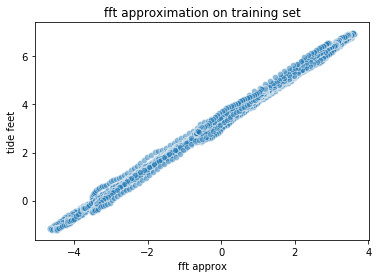

In [20]:
seaborn.scatterplot(x='fft approx', y='tide feet', 
                    data=dtrain, 
                    alpha=0.5)
info = matplotlib.pyplot.title("fft approximation on training set")

In [21]:
sklearn.metrics.r2_score(dtrain['tide feet'], dtrain['fft approx'])

-2.238582384820625

In [22]:
# freqs are defined as cycles per sample spacing
freqs = numpy.fft.fftfreq(dtrain.shape[0])
freqs = numpy.sort(numpy.unique([abs(f) for f in freqs[pick]]))
freqs = [f for f in freqs if f > 0]

In [23]:
periods_seconds = [sample_spacing_seconds/f for f in freqs]

In [24]:
vars = []
for ps in periods_seconds:
    vs = 'sin(second/' + str(ps) + ')'
    dtrain[vs] = numpy.sin(2*numpy.pi*dtrain['dts']/ps)
    tides[vs] = numpy.sin(2*numpy.pi*tides['dts']/ps)
    vc = 'cos(second/' + str(ps) + ')'
    dtrain[vc] = numpy.cos(2*numpy.pi*dtrain['dts']/ps)
    tides[vc] = numpy.cos(2*numpy.pi*tides['dts']/ps)
    vars = vars + [vs, vc]
    

In [25]:
fitter = sklearn.linear_model.ElasticNet(fit_intercept=True, 
                                         alpha = 1e-4,
                                         max_iter=10000)
fitter.fit(dtrain[vars], dtrain['tide feet'])
#fitter.coef_

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
dtrain['predict'] = fitter.predict(dtrain[vars])

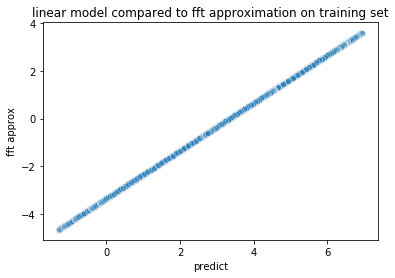

In [27]:
seaborn.scatterplot(x='predict', y='fft approx', 
                    data=dtrain, alpha=0.5)
info = matplotlib.pyplot.title("linear model compared to fft approximation on training set")

Now try to extrapolate.

In [28]:
tides['predict'] = fitter.predict(tides[vars])

In [29]:
dtest = tides.loc[numpy.logical_not(tides['train']), :].copy()
dtest.reset_index(inplace=True, drop=True)

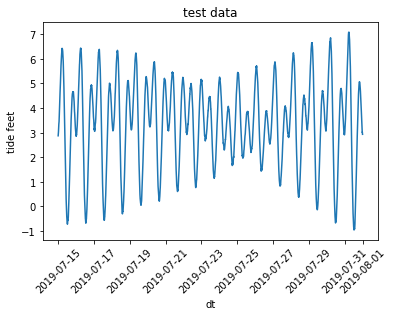

In [30]:
seaborn.lineplot(x='dt', y='tide feet', 
                 data=dtest)
info = matplotlib.pylab.xticks(rotation=45)
info = matplotlib.pyplot.title("test data")

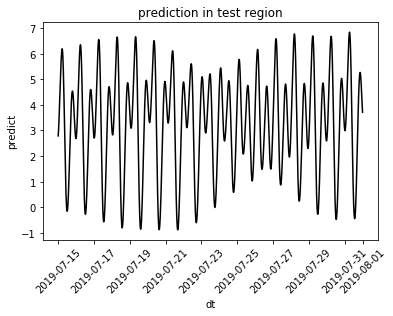

In [31]:
seaborn.lineplot(x='dt', y='predict', 
                 data=dtest, color='black')
info = matplotlib.pylab.xticks(rotation=45)
info = matplotlib.pyplot.title("prediction in test region")

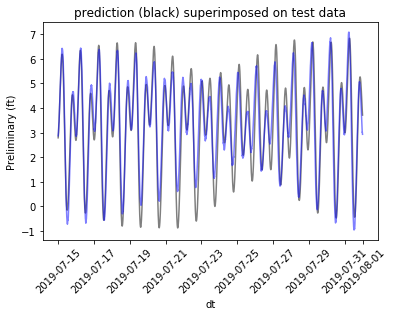

In [32]:
test_plot = tides.loc[numpy.logical_not(tides['train']), :]
seaborn.lineplot(x='dt', y='predict', 
                 data=test_plot,
                 color='black',
                 alpha=0.5)
seaborn.lineplot(x='dt', y='Preliminary (ft)', 
                 data=test_plot, 
                 color='blue',
                 alpha=0.5)
info = matplotlib.pylab.xticks(rotation=45)
info = matplotlib.pyplot.title("prediction (black) superimposed on test data")

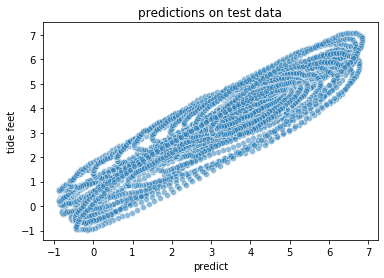

In [33]:
seaborn.scatterplot(x='predict', y='tide feet', 
                    data=dtest, 
                    alpha=0.5)
info = matplotlib.pyplot.title("predictions on test data")

In [34]:
sklearn.metrics.r2_score(dtest['tide feet'], dtest['predict'])

0.8098615395692726

Now try to cross-validate for better regularization parameters.

In [35]:
alphas = [ 10 ** k for k in range(-5, 5, 1) ]
print(alphas)
l1_ratios = numpy.arange(0, 1, 0.05)
print(l1_ratios)
grid = [ [ {"alpha": alpha, "l1_ratio": l1_ratio} for alpha in alphas ] for l1_ratio in l1_ratios ]
grid = functools.reduce(operator.concat, grid)
grid[0]

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]


{'alpha': 1e-05, 'l1_ratio': 0.0}

In [36]:
def cross_predict_model(fitter, X, Y, plan):
    preds = numpy.zeros(X.shape[0])
    for g in range(len(plan)):
        pi = plan[g]
        model = fitter.fit(X.iloc[pi["train"]], Y.iloc[pi["train"]])
        predg = model.predict(X.iloc[pi["app"]])
        preds[pi["app"]] = predg
    return preds

def est_quality(settings, plan, dtrain, mvars, outcome='y'):
    fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], 
                                             l1_ratio = settings["l1_ratio"], fit_intercept=True)
    preds = cross_predict_model(fitter, dtrain[mvars], dtrain[outcome], plan)
    mean_sq_error = numpy.mean((dtrain[outcome] - preds)**2)
    return mean_sq_error

In [37]:
fitter = sklearn.linear_model.ElasticNet(fit_intercept=True, 
                                         max_iter=10000)
cross_plan = vtreat.cross_plan.order_cross_plan(k_folds=5, order_vector=dtrain['dts'])

In [38]:
%%capture
param_evals = [ {"settings" : settings, "loss" : est_quality(settings, cross_plan, dtrain, vars, 'tide feet')} for settings in grid ]

In [39]:
min_loss = numpy.min([ q["loss"] for q in param_evals ])
best_params = [ q for q in param_evals if q["loss"] <= min_loss + 1e-9 ]
best_params

[{'settings': {'alpha': 0.001, 'l1_ratio': 0.9500000000000001},
  'loss': 0.25550772437890235}]

In [40]:
settings = best_params[0]["settings"]
fitter = sklearn.linear_model.ElasticNet(alpha = settings["alpha"], 
                                         l1_ratio = settings["l1_ratio"], 
                                         fit_intercept=True,
                                         max_iter=1000)
model = fitter.fit(dtrain[vars], dtrain['tide feet'])

In [41]:
dtest['pred2'] = fitter.predict(dtest[vars])

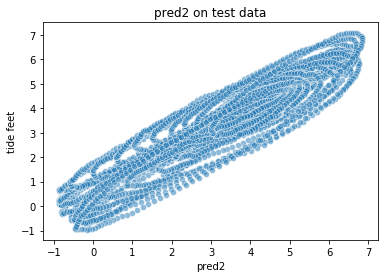

In [42]:
seaborn.scatterplot(x='pred2', y='tide feet', 
                    data=dtest, 
                    alpha=0.5)
info = matplotlib.pyplot.title("pred2 on test data")

In [43]:
sklearn.metrics.r2_score(dtest['tide feet'], dtest['pred2'])

0.8133030502543819

No real change in this case.